# Boundary padding illustration

* This notebook shows the boundary padding in CREDIT

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

import torch
from credit.boundary_padding import TensorPadding

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
%matplotlib inline

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
import verif_utils as vu

### Load config

In [2]:
config_name = os.path.realpath('plot_config.yml')

with open(config_name, 'r') as stream:
    conf = yaml.safe_load(stream)

### Figure settings

In [3]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = conf['figure']['keys']['dpi']
else:
    dpi_ = 75

### Load land mask & apply padding

In [4]:
ds_static = xr.open_dataset('/glade/derecho/scratch/ksha/CREDIT_data/static_norm_old.nc')

In [5]:
land_mask = ds_static['LSM'].values
land_mask_pad = torch.from_numpy(land_mask[None, None, ])

pad_x = 80
pad_y = 80

padding_conf_earth = {'mode': 'earth', 
                      'pad_lat': [pad_y, pad_y], 
                      'pad_lon': [pad_x, pad_x]}
pad_opt_earth = TensorPadding(**padding_conf_earth)

land_mask_pad_earth = pad_opt_earth.pad(land_mask_pad)
land_mask_pad_earth = land_mask_pad_earth.numpy().squeeze()

padding_conf_mirror = {'mode': 'mirror', 
                      'pad_lat': [pad_y, pad_y], 
                      'pad_lon': [pad_x, pad_x]}

pad_opt_mirror = TensorPadding(**padding_conf_mirror)

land_mask_pad_mirror = pad_opt_mirror.pad(land_mask_pad)
land_mask_pad_mirror = land_mask_pad_mirror.numpy().squeeze()

land_mask = np.flipud(land_mask)
land_mask_pad_earth = np.flipud(land_mask_pad_earth)
land_mask_pad_mirror = np.flipud(land_mask_pad_mirror)

### Plot

**Figure specs**

In [6]:
grid_shape = land_mask.shape
grid_shape_pad = land_mask_pad_earth.shape
fig_ratio = grid_shape_pad[0]/grid_shape_pad[1]

my_colors = gu.ksha_color_set_summon(color_set=0)
red = my_colors['red']
blue = my_colors['blue']

**Create the figure**

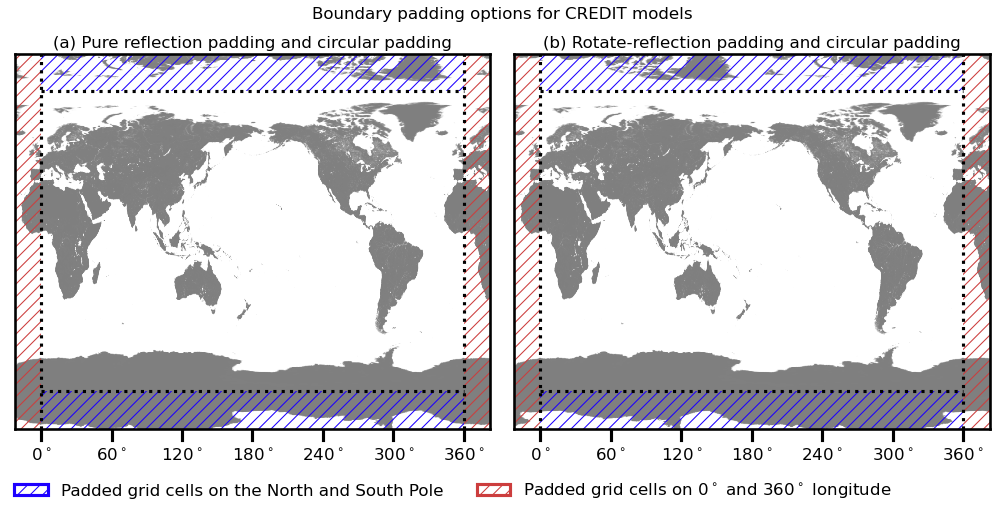

In [7]:
fig = plt.figure(figsize=(13, fig_ratio*9), dpi=dpi_)
gs = gridspec.GridSpec(1, 3, height_ratios=[1,], width_ratios=[1, 0.05, 1])

AX = []
AX.append(plt.subplot(gs[0, 0]))
AX.append(plt.subplot(gs[0, 2]))

for ax in AX:
    ax = gu.ax_decorate_box(ax)
plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.0)

AX[0].pcolormesh(land_mask_pad_mirror, vmin=0.0, vmax=2, cmap=plt.cm.gray_r)
AX[1].pcolormesh(land_mask_pad_earth, vmin=0.0, vmax=2, cmap=plt.cm.gray_r)

for ax in AX:
    patch_rec1 = patches.Rectangle((pad_x, 0), grid_shape[1], pad_y, 
                                   linewidth=0, edgecolor=blue, facecolor='none', hatch='//')
    patch_rec2 = patches.Rectangle((pad_x, grid_shape_pad[0]-pad_y), grid_shape[1], pad_y, 
                                   linewidth=0, edgecolor=blue, facecolor='none', hatch='//')
    patch_rec3 = patches.Rectangle((0, 0), pad_x, grid_shape_pad[0], 
                                   linewidth=0, edgecolor=red, facecolor='none', hatch='//')
    patch_rec4 = patches.Rectangle((grid_shape_pad[1]-pad_x, 0), pad_x, grid_shape_pad[0], 
                                   linewidth=0, edgecolor=red, facecolor='none', hatch='//')
    
    ax.vlines(x=pad_x, ymin=0, ymax=grid_shape_pad[0], linewidth=3, linestyle=':', color='k')
    ax.vlines(x=grid_shape_pad[1]-pad_x, ymin=0, ymax=grid_shape_pad[0], linewidth=3, linestyle=':', color='k')
    
    ax.hlines(y=pad_y, xmin=pad_x, xmax=grid_shape_pad[1]-pad_x, linewidth=3, linestyle=':', color='k')
    ax.hlines(y=grid_shape_pad[0]-pad_y, xmin=pad_x, xmax=grid_shape_pad[1]-pad_x, linewidth=3, linestyle=':', color='k')

    ax.add_patch(patch_rec1)
    ax.add_patch(patch_rec2)
    ax.add_patch(patch_rec3)
    ax.add_patch(patch_rec4)

AX[0].set_title('(a) Pure reflection padding and circular padding', fontsize=16)
AX[1].set_title('(b) Rotate-reflection padding and circular padding', fontsize=16)

# ------------------------------------------------------------ #
# xlabel left
label_lon = np.arange(0, 360+60, 60)
loc_x = np.linspace(pad_x, grid_shape_pad[1]-pad_x, len(label_lon))/grid_shape_pad[1]

ax_label1 = fig.add_axes([0, -0.1, 1/2.05, 0.1])
for i_label, lon in enumerate(label_lon):
    ax_label1.text(loc_x[i_label], 0.5, '{}$^\circ$'.format(lon), 
                   va='top', ha='center', fontsize=16, transform=ax_label1.transAxes)
    ax_label1.axvline(x=loc_x[i_label], ymin=0.7, ymax=1.0, linewidth=3, color='k')

# ------------------------------------------------------------ #
# xlabel right
ax_label2 = fig.add_axes([1.05/2.05, -0.1, 1/2.05, 0.1])
for i_label, lon in enumerate(label_lon):
    ax_label2.text(loc_x[i_label], 0.5, '{}$^\circ$'.format(lon), 
                   va='top', ha='center', fontsize=16, transform=ax_label2.transAxes)
    ax_label2.axvline(x=loc_x[i_label], ymin=0.7, ymax=1.0, linewidth=3, color='k')

# ------------------------------------------------------------ #
# legend
handle_lg = []
handle_lg.append(patches.Patch(linewidth=3, edgecolor=blue, facecolor='none', hatch='//', label=''))
handle_lg.append(patches.Patch(linewidth=3, edgecolor=red, facecolor='none', hatch='//', label=''))

#ax_lg1 = fig.add_axes([(1-0.925)/2, -0.215, 0.925, 0.115])
ax_lg1 = fig.add_axes([0, -0.215, 0.915, 0.115])
LG1 = ax_lg1.legend(handle_lg, ['Padded grid cells on the North and South Pole', 
                                'Padded grid cells on 0$^\circ$ and 360$^\circ$ longitude',], 
                    bbox_to_anchor=(1, 1), ncol=2, prop={'size':16})

ax_title1 = fig.add_axes([0.0, 1.075, 1.0, 0.05])
ax_title1.text(0.5, 1.0, 'Boundary padding options for CREDIT models', ha='center', va='top', fontsize=16)

LG1 = gu.lg_box(LG1)
ax_lg1.set_axis_off()
ax_title1.set_axis_off()
ax_label1.set_axis_off()
ax_label2.set_axis_off()